# celeba-hq

In [1]:
import os

In [2]:
from miniai.imports import *
from miniai.diffusion import *

from glob import glob
from fastprogress import progress_bar
from diffusers import AutoencoderKL, UNet2DConditionModel

In [3]:
import timm
import shutil

In [4]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Data processing

In [5]:
# xl,yl = 'image','label'
# bs = 8*8*4//8//2
# sz=256
# dsd=load_dataset("imagefolder", data_dir='/home/christ/dev/course22p2/nbs/data/celeba-hq')
# ds_len=30000
# dsd

In [6]:
# @inplace
# def transformi(b): b[xl] = [TF.resize(TF.to_tensor(o),[sz,sz]) for o in b[xl]]

# tds = dsd.with_transform(transformi)

In [7]:
# def img_collate(b): return default_collate(b)[xl]
# dl = DataLoader(tds['train'], batch_size=bs, collate_fn=img_collate, num_workers=4, shuffle=False)

In [8]:
# xb = next(iter(dl))
# show_images((xb[:16]).clip(0,1), imsize=2)

## VAE

In [9]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").cuda().requires_grad_(False)

In [10]:
mmpath = Path('data/celeba-hq/data.npmm')

In [11]:
# len(tds['train'])

In [12]:
#len(ds)

In [13]:
#mmshape = (303125,4,32,32)
mmshape = (30000,4,32,32)

In [14]:
# if not mmpath.exists():
#     a = np.memmap(mmpath, np.float32, mode='w+', shape=mmshape)
#     i = 0
#     for b in progress_bar(dl):
#         n = len(b)
#         a[i:i+n] = to_cpu(vae.encode(b.cuda()).latent_dist.mean).numpy()
#         i += n
#     a.flush()
#     del(a)

In [15]:
lats = np.memmap(mmpath, dtype=np.float32, mode='r', shape=mmshape)

In [16]:
b = torch.tensor(lats[:16])

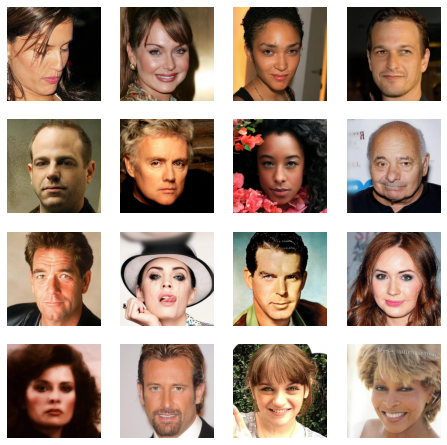

In [17]:
xd = to_cpu(vae.decode(b.cuda()))
show_images(xd['sample'].clamp(0,1), imsize=2)

## Noisify

In [18]:
def collate_ddpm(b): return noisify(default_collate(b)*0.2)

In [19]:
n = len(lats)

In [20]:
tds = lats[:n//10*9 ]
vds = lats[ n//10*9:]

In [21]:
bs = 64#128

In [22]:
dls = DataLoaders(*get_dls(tds, vds, bs=bs, num_workers=fc.defaults.cpus, collate_fn=collate_ddpm))

In [23]:
import warnings

In [24]:
warnings.simplefilter('ignore', UserWarning)

In [25]:
(xt,t),eps = b = next(iter(dls.train))

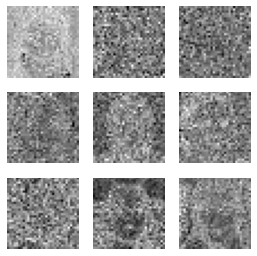

In [26]:
show_images(xt[:9,0], imsize=1.5)

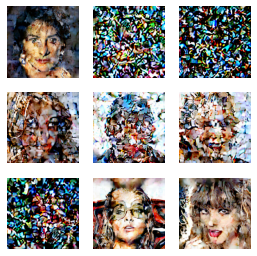

In [27]:
xte = vae.decode(xt[:9].cuda()*5)['sample']
show_images(xte.clamp(0,1), imsize=1.5)

## Train

In [28]:
def init_ddpm(model):
    for o in model.downs:
        for p in o.resnets: p.conv2[-1].weight.data.zero_()

    for o in model.ups:
        for p in o.resnets: p.conv2[-1].weight.data.zero_()

In [29]:
def conv(ni, nf, ks=3, stride=1, act=nn.ReLU, norm=None, bias=True):
    layers = []
    if norm: layers.append(norm(ni))
    if act : layers.append(act())
    layers.append(nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias))
    return nn.Sequential(*layers)

def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
    return nn.Sequential(conv(ni, nf, stride=1     , act=act, norm=norm, ks=ks),
                         conv(nf, nf, stride=stride, act=act, norm=norm, ks=ks))

class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride, act=act, ks=ks, norm=norm)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None, norm=norm)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return self.convs(x) + self.idconv(self.pool(x))

def res_blocks(n_bk, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
    return nn.Sequential(*[
        ResBlock(ni if i==0 else nf, nf, stride=stride if i==n_bk-1 else 1, ks=ks, act=act, norm=norm)
        for i in range(n_bk)])

def get_dropmodel(nfs, nbks, act=act_gr, norm=nn.BatchNorm2d, drop=0.2):
    layers = [nn.Conv2d(4, nfs[0], 5, padding=2)]
    layers += [res_blocks(nbks[i], nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
               for i in range(len(nfs)-1)]
    layers += [act_gr(), norm(nfs[-1]), nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(drop)]
    layers += [nn.Linear(nfs[-1], 1000, bias=False), nn.BatchNorm1d(1000)]
    return nn.Sequential(*layers).apply(iw)

In [30]:
clean_mem()

In [31]:
lr = 3e-3
epochs = 250
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = EmbUNetModel(in_channels=4, out_channels=4, nfs=(128, 256, 512, 768), num_layers=2,
                     attn_start=1, attn_chans=16)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

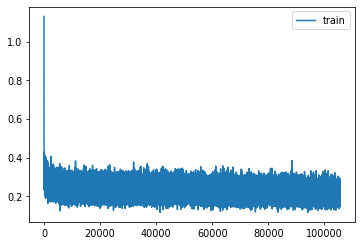

In [32]:
learn.fit(epochs)
#0.308	4	eval

In [33]:
clean_mem()

## Sampling

In [34]:
#sz = (16,4,32,32)
sz = (8,4,32,32)

In [35]:
# set_seed(42)
preds = sample(ddim_step, model, sz, steps=100, eta=1., clamp=False)

In [36]:
s = preds[-1]*5

In [37]:
clean_mem()

In [38]:
with torch.no_grad(): pd = to_cpu(vae.decode(s.cuda()))

In [39]:
clean_mem()

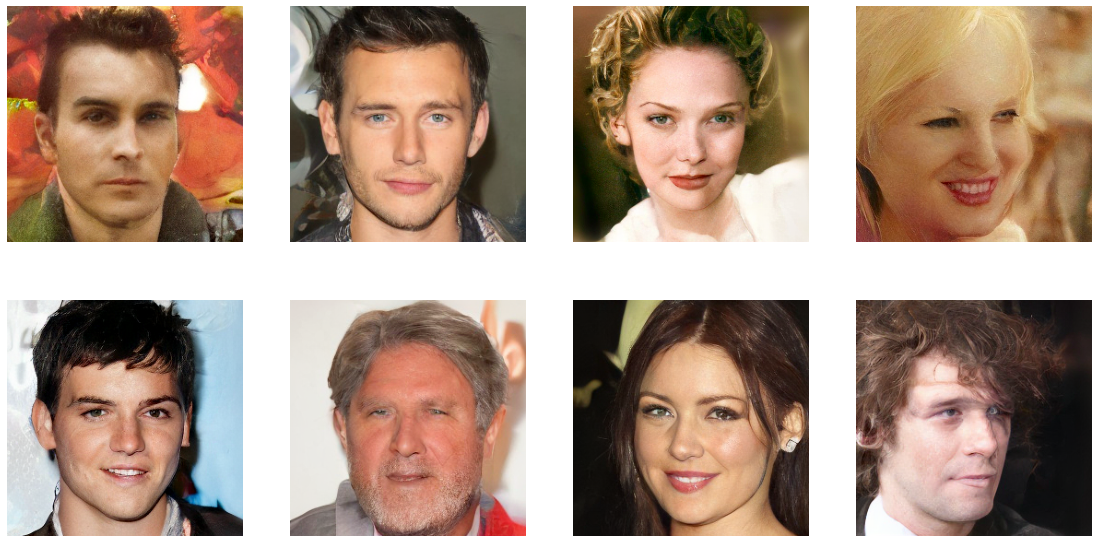

In [40]:
show_images(pd['sample'][:9].clamp(0,1), imsize=5)

In [41]:
torch.save(learn.model.state_dict(), 'models/celeb-latents-msee-only')

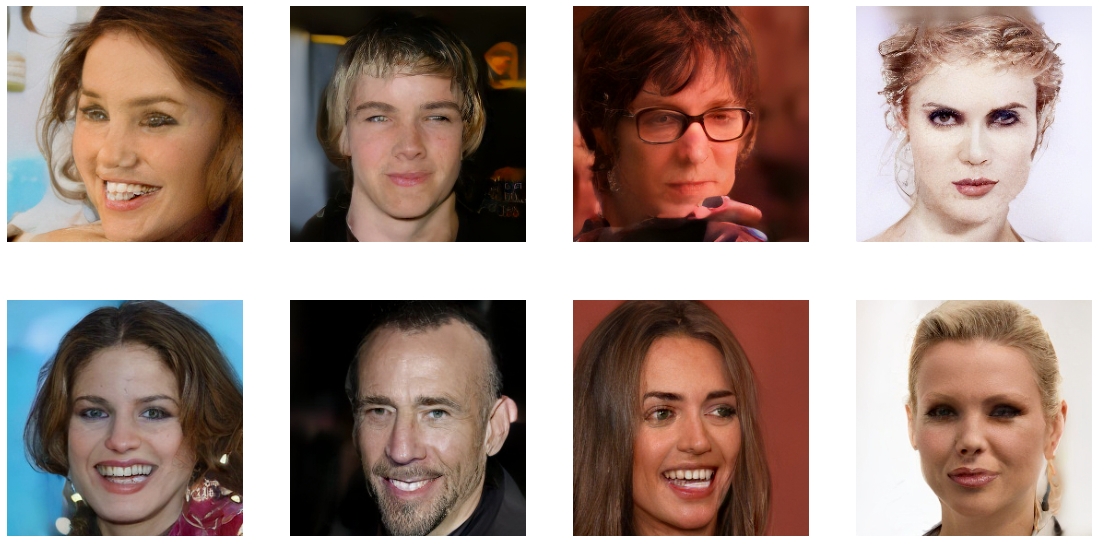

In [42]:
preds = sample(ddim_step, model, sz, steps=100, eta=1., clamp=False)
s = preds[-1]*5
clean_mem()
with torch.no_grad(): pd = to_cpu(vae.decode(s.cuda()))
clean_mem()
show_images(pd['sample'][:9].clamp(0,1), imsize=5) 

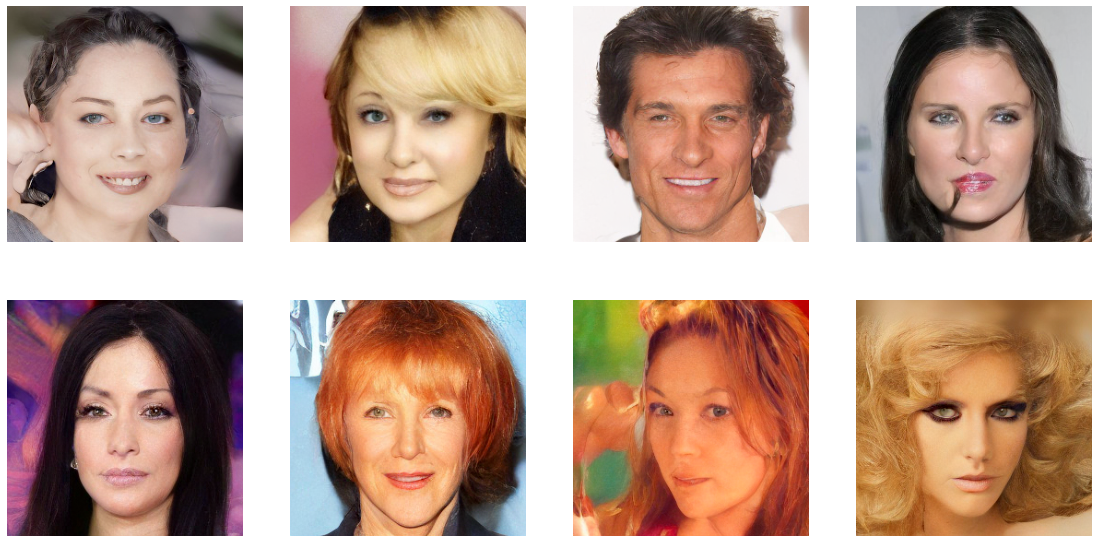

In [43]:
preds = sample(ddim_step, model, sz, steps=100, eta=1., clamp=False)
s = preds[-1]*5
clean_mem()
with torch.no_grad(): pd = to_cpu(vae.decode(s.cuda()))
clean_mem()
show_images(pd['sample'][:9].clamp(0,1), imsize=5) 

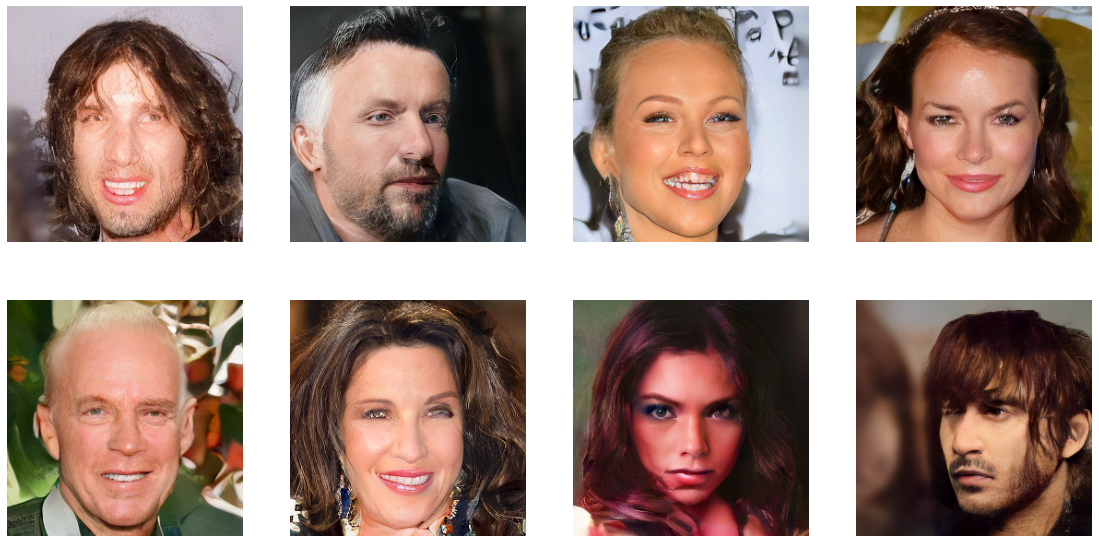

In [44]:
preds = sample(ddim_step, model, sz, steps=100, eta=1., clamp=False)
s = preds[-1]*5
clean_mem()
with torch.no_grad(): pd = to_cpu(vae.decode(s.cuda()))
clean_mem()
show_images(pd['sample'][:9].clamp(0,1), imsize=5) 